# Modeling with deep neural networks Parachor factors in compounds.

# Abstract
We implement a neural network to determine the value of the Parachor coefficient in 227 pure chemical compounds. For a given compound, the neural network can discriminate the group contribution. We took into account only the chemical formulas represented by the functional group as the features used in our modeling.

# Introduction
The interfacial tension (IFT) created by molecules in a fluid can be expressed as,

$IFT^{0.25} = \frac{P(\rho_{L}-\rho_{V})}{M}$,

where $\rho_{L}$ and $\rho_{L}$ are the densities ($kg/m^{3}$) in the liquid and vapor phases, respectevely, and $M$ is the molecular weight. IFT is measured  in units of force exerted at the interface per unit length. The proportional term  $P$ is known as the Parachor factor, it is a number that represents the molar volume of a
compound when its temperature is such that its surface tension is unity.

One way that,P can be estimated is by the next relation:

$P=0.324T^{1/4}_{c}v^{7/8}_{c}$,

where T ($K$) and $v$ are ythe temperature and and molar volume at critical values.

In this work, we abtain a neural network which is allow us to estimate $P$ when only the group composition of a pure chemical compound is available. This is certantly a very convinent alternative, when any of the variables of the above equations cannot be accesed. From out of 40 groups we consider for training our model, 20 are displayed below in a table. The modeling is based on TensorFlow.

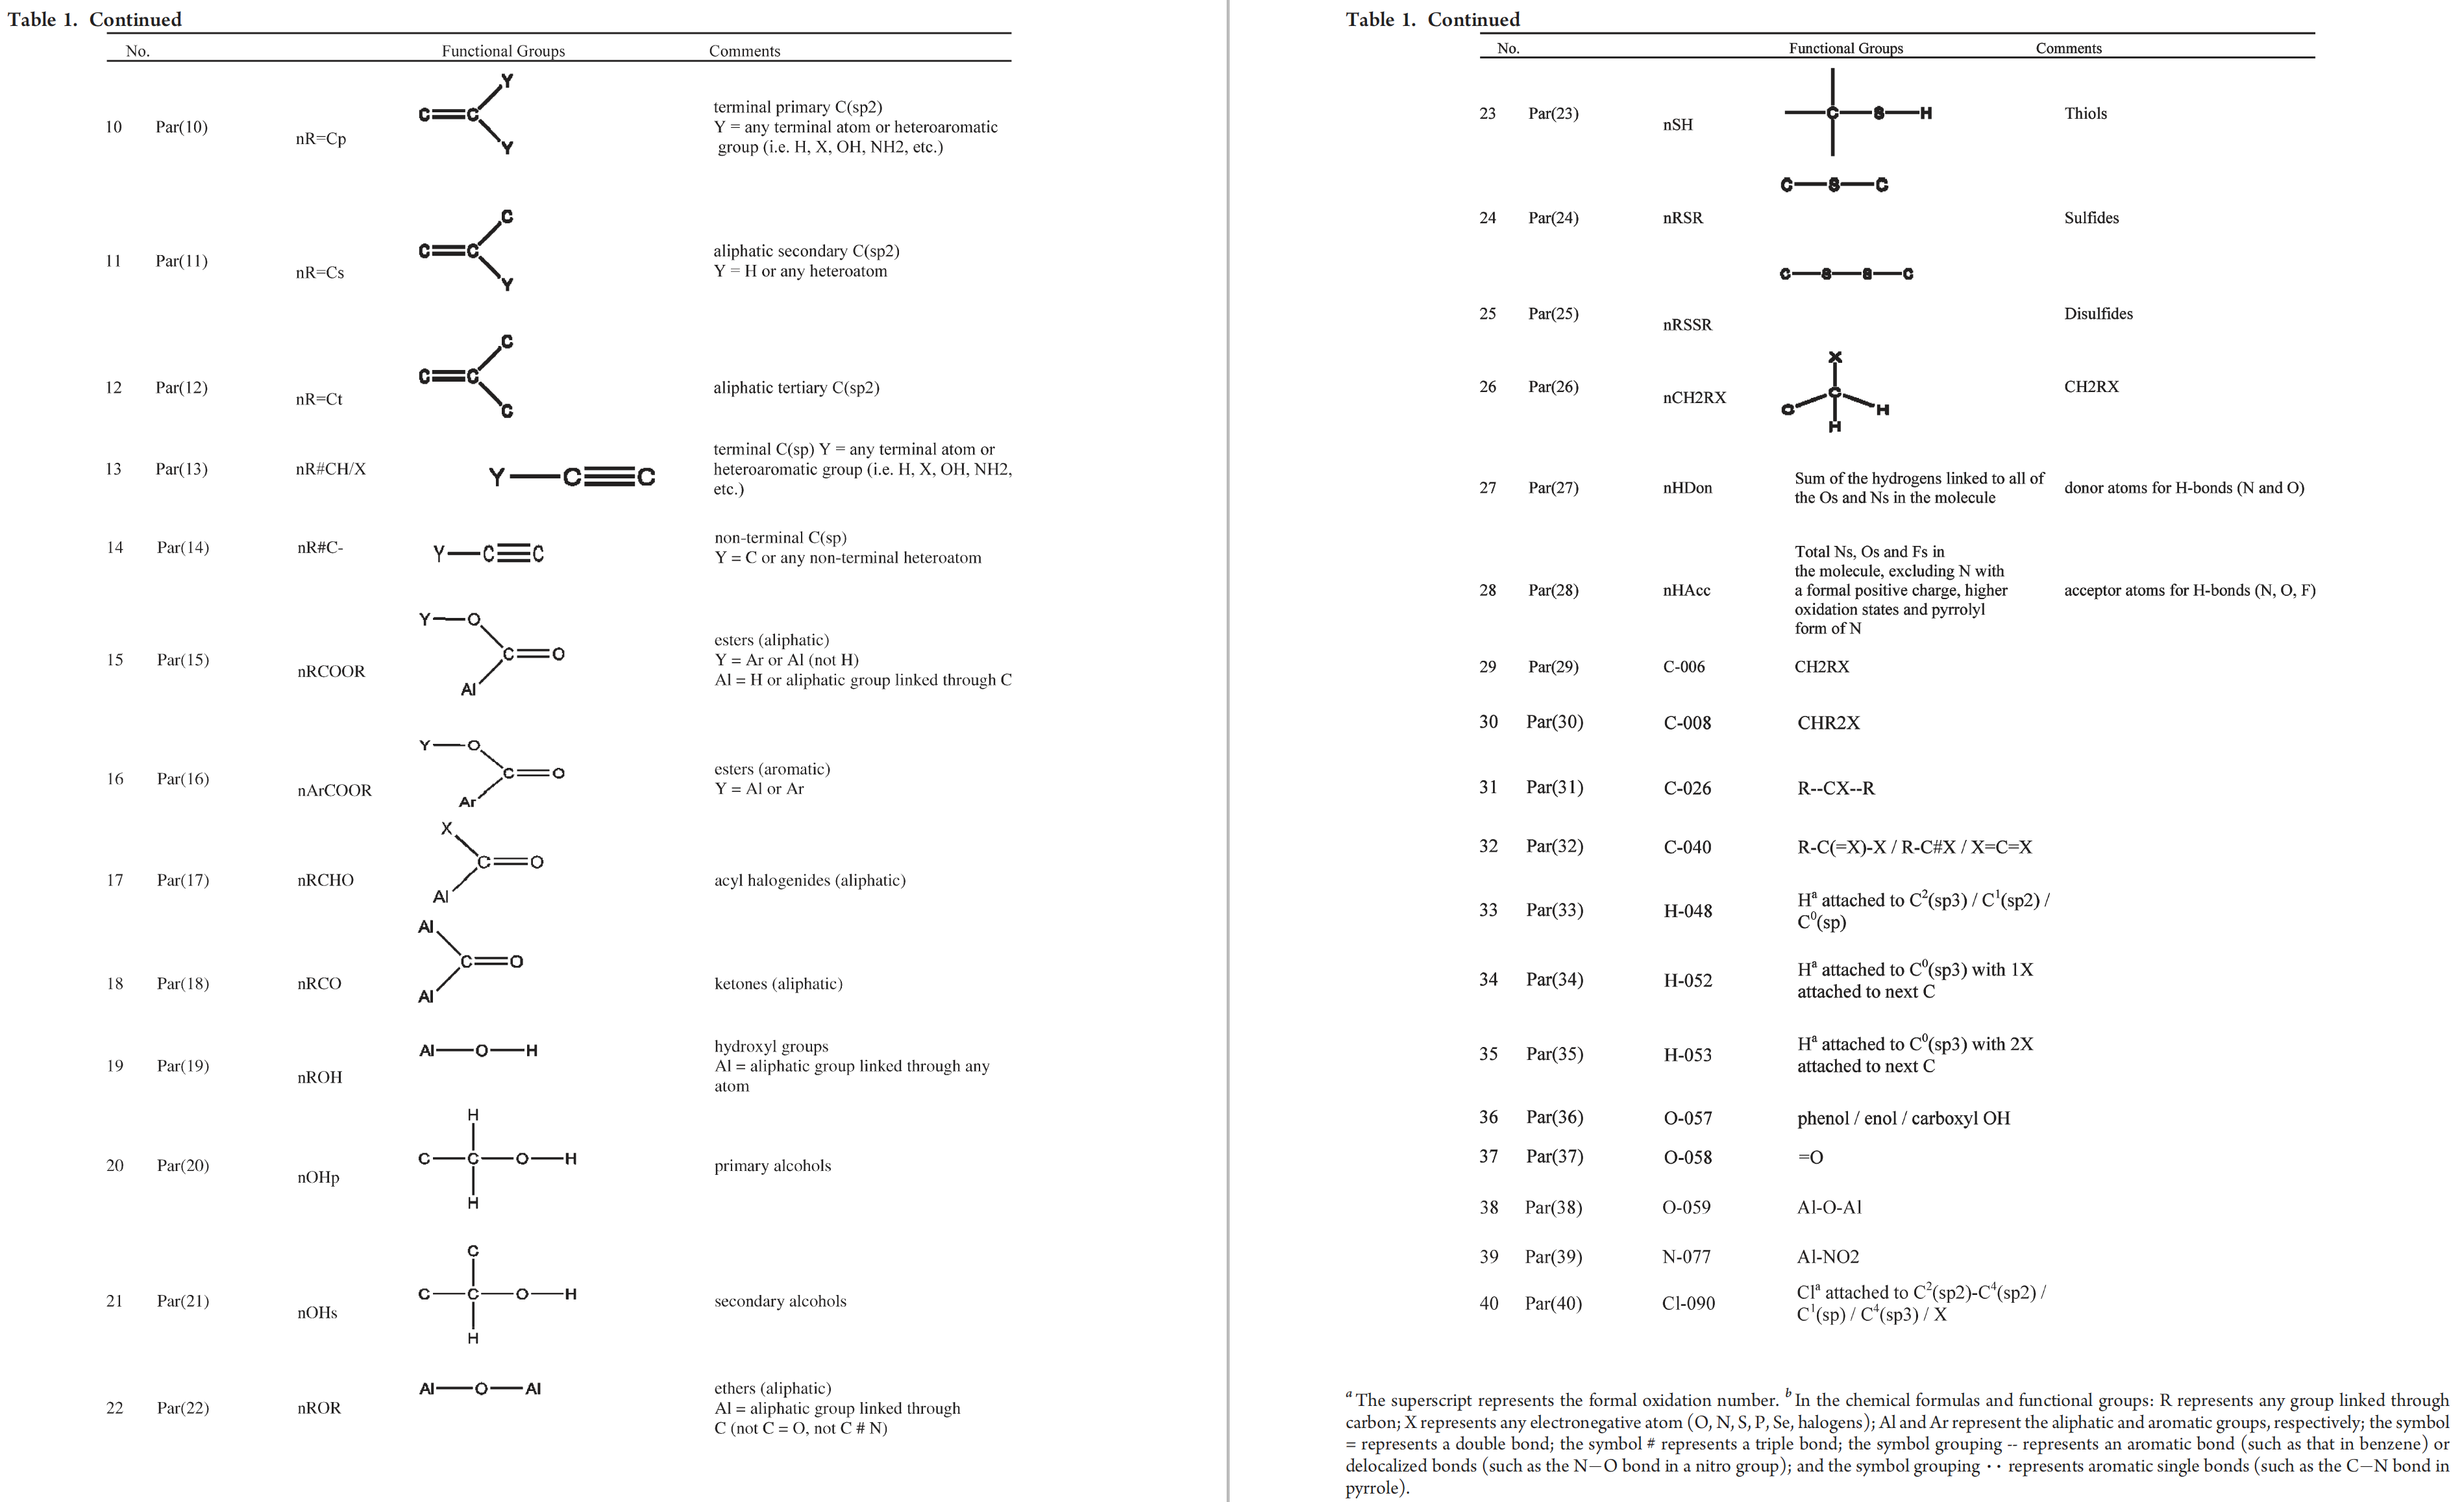

In [25]:
from IPython.display import Image
Image('groups.png', width = 1200, height = 900)

For a more detailed discussion, I recommend taking a look at the paper of Gharagheizi et al (https://pubs.acs.org/doi/10.1021/ie102464t), who applied a similar method. The architecture of the best neural network I obtained differs from this paper, but the accuracy is the same. Next, I follow a standard procedure for data pre-processing. 

In [20]:
# Imported modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow import keras
from keras.metrics import MeanSquaredError

# Read and transform data 

In [4]:
df = pd.read_csv('parachor_thermalcond.csv')
# print(df.head())
df.keys()
# print(df.isnull().sum())# No missing values

# Take the last 40 columns which are the number 
# of functional groups in the compound. These are the features.
X = np.array(df)[:,-40:]
X = np.array(X,dtype=float)
print(np.shape(X))

# Label data
y = np.array(df['Parachor'])
y = np.reshape(y, (-1,1)) #Transform a 1D to a 2D array suitable for scalers

(227, 40)


# Scaling and splitting data

In [11]:
scaler = MinMaxScaler(feature_range=(0,1))
#scaler = RobustScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

# Split the data
trainperc = 0.8
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=trainperc,
                                                   random_state=42)

# Set the neural network
The architecture I am presenting was the best-optimized structure I could obtain. I did not use any exhaustive technique, like Grid Search, but rather some guesses on how to choose the number of layers and activation functions, as well as avoiding overfitting by using a Callback class of TensorFlow. Among the tested architecture are: (40,20,16,2,1), (20,20,10,1), (20,20,10,5,5,1), with either Relu or Linear as activation functions. Different percentage of training data were tested (70%, 80%, 85%, 90%).

In [6]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(20, input_dim=40, activation='linear'))
model.add(keras.layers.Dense(20, activation='linear'))
model.add(keras.layers.Dense(8, activation='linear'))
model.add(keras.layers.Dense(2, activation='linear'))
model.add(keras.layers.Dense(1, activation='relu'))
model.compile(loss="mean_squared_error", optimizer="adam",
                  metrics=['MeanSquaredError'])

callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error',
                                          patience=50,
                                          mode="auto")

# train the model
history = model.fit(X_train,y_train,epochs=600, verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=50,
                    shuffle=True, callbacks=[callback])

print(history.history.keys())
len(history.history['mean_squared_error'])

2022-06-19 15:24:36.157591: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


317

# Test data

In [7]:
mse = MeanSquaredError()

y_pred_train = model.predict(X_train, verbose=False)
mse.update_state(y_train, y_pred_train)
print('MSE of train data:', mse.result().numpy())

y_pred_test = model.predict(X_test, verbose=False)
mse.update_state(y_test, y_pred_test)
print('MSE of test data:', mse.result().numpy())

MSE of train data: 0.00021694649
MSE of test data: 0.0003303159


# Plots

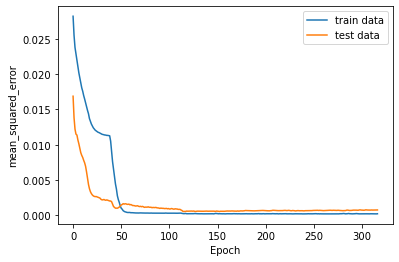

In [8]:
#  Plot of  mean square error to see how early stop voids overfitting 
# and chose best score for train and test data.

plt.plot(history.history['mean_squared_error'], label='train data')
plt.plot(history.history['val_mean_squared_error'], label='test data')
plt.xlabel('Epoch')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

2/2 [==============================] - 0s 11ms/step


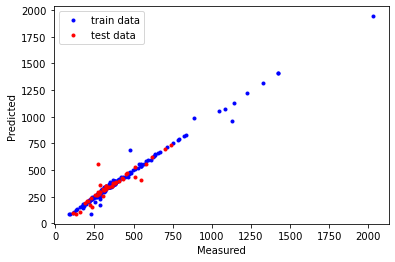

In [9]:
# Compare training vs test data one-to-one (45 degre line)

# predict
Y1P = model.predict(X_train)
Y2P = model.predict(X_test)

# unscale for plotting and analysis
ymin = scaler.min_[-1]
yrange = scaler.scale_[-1]

Y1u = (y_train-ymin)/yrange
Y1Pu = (Y1P-ymin)/yrange

Y2u = (y_test-ymin)/yrange
Y2Pu = (Y2P-ymin)/yrange

sae1 = 0.0
for i in range(len(Y1u)):
    sae1 += np.abs(Y1u[i]-Y1Pu[i][0])/Y1u[i]
sae1 = sae1 / len(Y1u)

sae2 = 0.0
for i in range(len(Y2u)):
    sae2 += np.abs(Y2u[i]-Y2Pu[i][0])/Y2u[i]
sae2 = sae2 / len(Y2u)


plt.figure()
plt.plot(Y1u, Y1Pu, 'b.',label='train data')
plt.plot(Y2u, Y2Pu, 'r.',label='test data')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.legend(loc='best')
plt.show()

# Summary
From all the tested artificial neural architectures with different activation functions and different percentages of training data, the (20, 20, 8, 2, 1) layer distribution with (linear, linear, linear, linear, Relu) activation functions and 80 % of training data, proved to be the best option. The above plot, Predicted vs Measured, shows however that the model could be improved. This is inferred from the three outliers' red points.

Finally, I also calculated results for the neural network obtained by Gharagheizi et al. Although they used Matlab, different scores to evaluate, and different activation functions, the (40-5-1) they proposed has similar results to the model that I have developed here with only linear actuvation functions and 80% of training data.

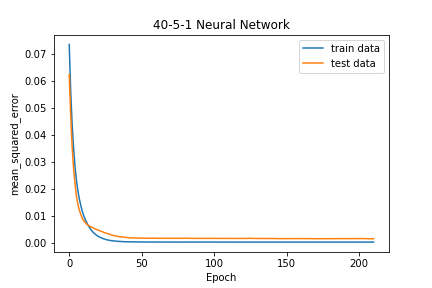

In [17]:
Image('40-5-1_epochs.png')

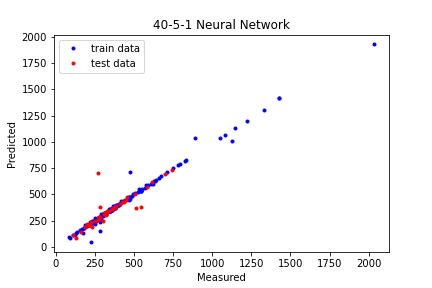

In [16]:
Image('40-5-1_line.png')